### Based on: https://docs.pystiche.org/en/stable/galleries/examples/advanced/example_model_optimization.html#sphx-glr-galleries-examples-advanced-example-model-optimization-py

### Imports

In [24]:
import contextlib
import os
import time
from collections import OrderedDict
from os import path

import torch
from torch import hub, nn
from torch.nn.functional import interpolate

import pystiche
from pystiche import demo, enc, loss, optim
from pystiche.image import show_image
from pystiche.misc import get_device

In [25]:
device = get_device()

In [26]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor=1.0, mode="nearest"):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, input):
        return interpolate(input, scale_factor=self.scale_factor, mode=self.mode, )

    def extra_repr(self):
        extras = []
        if self.scale_factor:
            extras.append(f"scale_factor={self.scale_factor}")
        if self.mode != "nearest":
            extras.append(f"mode={self.mode}")
        return ", ".join(extras)

In [27]:
class Conv(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride=1,
            upsample=False,
            norm=True,
            activation=True,
    ):
        super().__init__()
        self.upsample = Interpolate(scale_factor=stride) if upsample else None
        self.pad = nn.ReflectionPad2d(kernel_size // 2)
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride=1 if upsample else stride
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if norm else None
        self.activation = nn.ReLU() if activation else None

        def forward(self, input):
            if self.upsample:
                input = self.upsample(input)
                output = self.conv(self.pad(input))
                if self.norm:
                    output = self.norm(output)
                    if self.activation:
                        output = self.activation(output)
                        return output

In [28]:
class Residual(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = Conv(channels, channels, kernel_size=3)
        self.conv2 = Conv(channels, channels, kernel_size=3, activation=False)

        def forward(self, input):
            output = self.conv2(self.conv1(input))
            return output + input

In [29]:
class FloatToUint8Range(nn.Module):
    def forward(self, input):
        return input * 255.0


class Uint8ToFloatRange(nn.Module):
    def forward(self, input):
        return input / 255.0

In [30]:
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Conv(3, 32, kernel_size=9),
            Conv(32, 64, kernel_size=3, stride=2),
            Conv(64, 128, kernel_size=3, stride=2),
            Residual(128),
            Residual(128),
            Residual(128),
            Residual(128),
            Residual(128),
        )
        self.decoder = nn.Sequential(
            Conv(128, 64, kernel_size=3, stride=2, upsample=True),
            Conv(64, 32, kernel_size=3, stride=2, upsample=True),
            Conv(32, 3, kernel_size=9, norm=False, activation=False),
        )

        self.preprocessor = FloatToUint8Range()
        self.postprocessor = Uint8ToFloatRange()

    def forward(self, input):
        input = self.preprocessor(input)
        output = self.decoder(self.encoder(input))
        return self.postprocessor(output)

In [39]:
transformer = pystiche.demo.transformer().to(device)

In [11]:
# transformer = Transformer().to(device)

In [32]:
transformer

Transformer(
  (encoder): Sequential(
    (0): Conv(
      (pad): ReflectionPad2d((4, 4, 4, 4))
      (conv): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
      (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (activation): ReLU()
    )
    (1): Conv(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (activation): ReLU()
    )
    (2): Conv(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (activation): ReLU()
    )
    (3): Residual(
      (conv1): Conv(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (norm): InstanceNorm2d(128, eps=1e-05, mo

In [33]:
multi_layer_encoder = enc.vgg16_multi_layer_encoder()
content_layer = "relu2_2"
content_encoder = multi_layer_encoder.extract_encoder(content_layer)
content_weight = 1e5
content_loss = loss.FeatureReconstructionLoss(
    content_encoder, score_weight=content_weight
)


class GramOperator(loss.GramLoss):
    def enc_to_repr(self, enc: torch.Tensor) -> torch.Tensor:
        repr = super().enc_to_repr(enc)
        num_channels = repr.size()[1]
        return repr / num_channels


style_layers = ("relu1_2", "relu2_2", "relu3_3", "relu4_3")
style_weight = 1e10
style_loss = loss.MultiLayerEncodingLoss(
    multi_layer_encoder,
    style_layers,
    lambda encoder, layer_weight: GramOperator(encoder, score_weight=layer_weight),
    layer_weights="sum",
    score_weight=style_weight,
)
perceptual_loss = loss.PerceptualLoss(content_loss, style_loss)
perceptual_loss = perceptual_loss.to(device)
print(perceptual_loss)

PerceptualLoss(
  (content_loss): FeatureReconstructionLoss(
    score_weight=100000
    (encoder): VGGMultiLayerEncoder(layer=relu2_2, arch=vgg16, framework=torch)
  )
  (style_loss): MultiLayerEncodingLoss(
    encoder=VGGMultiLayerEncoder(arch=vgg16, framework=torch), score_weight=1e+10
    (relu1_2): GramOperator()
    (relu2_2): GramOperator()
    (relu3_3): GramOperator()
    (relu4_3): GramOperator()
  )
)


### Training

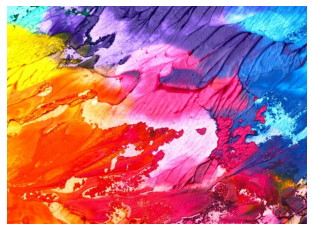

In [34]:
images = demo.images()
size = 500

style_image = images["paint"].read(size=size, device=device)
show_image(style_image)

In [15]:
def train(transformer, dataset, batch_size=4, epochs=2):
    if dataset is None:
        raise RuntimeError(
            "You forgot to define a dataset. For example, "
            "you can use any image dataset from torchvision.datasets."
        )

    from torch.utils.data import DataLoader

    image_loader = DataLoader(dataset, batch_size=batch_size)

    perceptual_loss.set_style_image(style_image)

    return optim.multi_epoch_model_optimization(
        image_loader, transformer.train(), perceptual_loss, epochs=epochs,
    )

### Using pretrained transformer

In [35]:
import ssl

# Highly discouraged but otherwise it does not want to work
ssl._create_default_https_context = ssl._create_unverified_context

In [36]:
use_pretrained_transformer = True
checkpoint = "example_transformer.pth"

if use_pretrained_transformer:
    if path.exists(checkpoint):
        state_dict = torch.load(checkpoint)
    else:
        # Unfortunately, torch.hub.load_state_dict_from_url has no option to disable
        # printing the downloading process. Since this would clutter the output, we
        # suppress it completely.
        @contextlib.contextmanager
        def suppress_output():
            with open(os.devnull, "w") as devnull:
                with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(
                        devnull
                ):
                    yield

        url = "https://download.pystiche.org/models/example_transformer.pth"

        with suppress_output():
            state_dict = hub.load_state_dict_from_url(url)

    transformer.load_state_dict(state_dict)
else:
    dataset = None
    transformer = train(transformer, dataset)

    state_dict = OrderedDict(
        [
            (name, parameter.detach().cpu())
            for name, parameter in transformer.state_dict().items()
        ]
    )
    torch.save(state_dict, checkpoint)

### NST

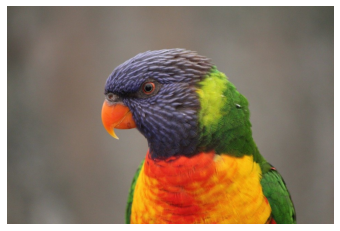

In [37]:
input_image = images['bird1'].read(size=size, device=device)
show_image(input_image)

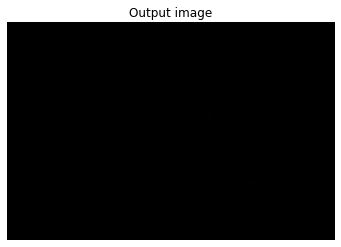

In [40]:
transformer.eval()

start = time.time()

with torch.no_grad():
    output_image = transformer(input_image)

stop = time.time()

show_image(output_image, 'Output image')